## Dependencies

In [2]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt

## Reading in parameters and topology data

In [3]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')

def InputTopology(data_file):
    inputdata = pd.read_excel(data_file,sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

In [11]:
start = '2018-09-01 00:00:00' #'2018-01-01 00:00:00'
end   = '2020-08-31 23:00:00' #'2019-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

#Load data scaling
input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.004)   #NEW CORRECT LOAD

hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour

rationing_price=max(market_prices_h.values())
print(rationing_price)

print(max(load_h.values()))


80.75
66.23236125654287


#Extracting inflow data from txt file

import pandas as pd
from datetime import datetime, timedelta

# Read the data from the .txt file
file_path = 'gkl_tilsig_ormsetfoss.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract date and inflow values
dates = []
inflows = []

for i in range(0, len(lines), 2):
    date_str = lines[i].strip()
    
    # Check if there are enough lines before accessing the next line
    if i + 1 < len(lines):
        inflow_str = lines[i + 1].strip().replace(',', '.')  # Replace ',' with '.' for decimal values
    else:
        inflow_str = ''
    
    # Skip lines that do not represent dates
    try:
        date = datetime.strptime(date_str, '%d/%m/%Y')
        dates.append(date)
        inflows.append(float(inflow_str))
    except ValueError:
        # Handle the case where the line is not a valid date
        pass

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Inflow': inflows})

# Create a new column for hourly inflow
df['Ormsetvatn'] = df['Inflow'] / 24

# Generate hourly data as a list of dictionaries
hourly_data_list = []

for _, row in df.iterrows():
    for hour in range(24):
        hourly_data_list.append({
            '': row['Date'] + timedelta(hours=hour),
            'Ormsetvatn': row['Ormsetvatn'],
            'Buavatn': row['Ormsetvatn'] * 0.0948
            #'Solar': row[]
        })

# Create DataFrame from the list of dictionaries
hourly_data = pd.DataFrame(hourly_data_list)

hourly_data.set_index('', inplace=True)
#df.set_index('', inplace=True)


# Save the result to a new CSV file
hourly_data.to_csv('Ormsetvatn_inflow.csv', index=False)


display(hourly_data)

#Extract correlation between Ormsetvatn and Buavatn and create corresponding dictionaries for each reservoir
res1, res2, solar=split_data('data/Data_inflow.csv')

orm_sum=0
bua_sum=0
for i in range(2018, 2022+1):
    orm_sum+=sum(res1[i].values())
    bua_sum+=sum(res2[i].values())
    
corr=bua_sum/orm_sum
print(corr)

orm=split_data2('Ormsetvatn_inflow.csv')

bua={}
for i in range(1972, 2002+1):
    bua[i]=scale_dict(orm[i], corr) 
    



#Extract 15 years of PV production data and duplicate it to a new CSV file
# Read CSV file
df = pd.read_csv('PV_production_15years.csv')

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Extract data for the years 2005 to 2020
data_2005_to_2020 = df[df['time'].dt.year.isin(range(2005, 2021))]

# Create a copy of the data for the years 1990 to 2004
data_1990_to_2004 = data_2005_to_2020.copy()

# Adjust the years in the copied data to be in the range 1990 to 2004
data_1990_to_2004['time'] = data_1990_to_2004['time'] - pd.DateOffset(years=15)

# Concatenate the original data and the copied data
final_data = pd.concat([data_1990_to_2004, data_2005_to_2020])

# Save the final data to a new CSV file
final_data.to_csv('PV_30years.csv', index=False)


#Create a dictionary for PV production data
import pandas as pd
df=pd.read_csv('PV_30years.csv')
display(df)

df.index = pd.to_datetime(df.index)
df['time'] = pd.to_datetime(df['time'])  # Convert the "time" column to datetime
df.set_index('time', inplace=True)  # Set the "time" column as the index

# Optionally, you can round down the minutes to the nearest hour
df.index = df.index.floor('H')

# Display the modified dataframe
print(df)
# Create a dictionary to store P-values for each year
PV_dict = {}

# Iterate over each year
for year in df.index.year.unique():
    PV_dict[year] = {}  # Dictionary for the current year

    # Iterate over each hour in a year (0 to 8759)
    for hour in range(8760):
        # Get the datetime for the current year and hour
        current_datetime = pd.Timestamp(f'{year}-01-01') + pd.DateOffset(hours=hour)

        # Check if the datetime exists in the DataFrame
        if current_datetime in df.index:
            # Extract P values
            PV = df.loc[current_datetime, 'P']
        else:
            # If the datetime is missing, set P values to zero
            PV = 0.0

        # Update dictionary
        PV_dict[year][hour] = PV

# Display the PV_dict dictionary
print(PV_dict)

#FIXING INFLOW

import pandas as pd

# Specify the path to your text file
file_path = "data/gkl_tilsig_ormsetfoss.txt"

# Read the text data into a pandas DataFrame
df = pd.read_csv(file_path, header=None, names=['Date', 'Value'], delim_whitespace=True)

# Combine the 'Date' and 'Value' columns into a single column
df['Combined'] = df['Date'].combine_first(df['Value'])

# Extract dates from 'Combined' to 'Datetime' and convert to datetime format
df['Datetime'] = pd.to_datetime(df['Combined'], format='%d/%m/%Y', errors='coerce')

# Remove rows where 'Combined' column contains date values
df = df[pd.isna(df['Datetime'])]

# Drop unnecessary columns
df.drop(['Date', 'Value', 'Datetime'], axis=1, inplace=True)

date_range = pd.date_range('1916-01-01', '2002-12-31', freq='D')
df['Combined'] = df['Combined'].str.replace(',', '.').astype(float)

actual_dataframe = pd.DataFrame(data=df['Combined'].astype(float).values, index=date_range, columns=['Ormsetvatn'])

hourly_dataframe = actual_dataframe.resample('H').mean()
hourly_dataframe = hourly_dataframe.fillna(method='ffill')

# Multiply values in the 'Ormsetvatn' column by 0.0958 to create the 'Buavatn' column
hourly_dataframe['Buavatn'] = hourly_dataframe['Ormsetvatn'] * 0.0948

scaling_factor_orm = 0.34469
scaling_factor_bua = 0.3447

hourly_dataframe['Ormsetvatn'] = hourly_dataframe['Ormsetvatn']*scaling_factor_orm
hourly_dataframe['Buavatn'] = hourly_dataframe['Buavatn']*scaling_factor_bua


sol = pd.read_csv('data/PV_30years_backward.csv')
sol['time'] = pd.to_datetime(sol['time'])
sol.set_index('time', inplace=True)

sol.index = sol.index - pd.DateOffset(minutes=11)

display(sol)

# Step 1: Merge the two dataframes based on the datetime index
merged_dataframe = pd.merge(hourly_dataframe, sol, how='left', left_index=True, right_index=True)

# Step 2: Drop duplicate columns, if any
merged_dataframe = merged_dataframe.loc[:, ~merged_dataframe.columns.duplicated()]

# Print the resulting merged DataFrame
merged_dataframe['Solar'].fillna(0, inplace=True)

print(merged_dataframe)
merged_dataframe.plot()

merged_dataframe.to_csv('100year_data_PVGIS.csv')

## Functions


In [4]:
# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 800, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3} }


# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.solar_toload[j] == model.L[j] - model.r[j]

def solar_rule(model,j):
    return model.sol[j] == model.solar_curt[j] + model.solar_toload[j]

#+ model.m['Buy',j]

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance



# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])


#def v_init_rule(model, i, v):
   #return model.v_init[i,v]==model.v0[i]*v/100
   
def pump_rule1(model,j): #Create a constraint for the conversion of discharge to power loss from the system...
    return  model.pump_loss_market1['Hydro2',j] == (model.pump1['Hydro2',j]*10**3)*(389*10**-6*constants['g']) #*( MW == kg/s * head * g * 100%  conversion_factor MW/(m^3/s))

def pump_rule2(model,j): #Create a constraint for the conversion of discharge to power loss from the system...
    return  model.pump_loss_market2['Hydro2',j] == (model.pump2['Hydro2',j]*10**3)*(389*10**-6*constants['g']) #*( MW == kg/s * head * g * 100%  conversion_factor MW/(m^3/s))

def pump_rule3(model,j): #Create a constraint for the conversion of discharge to power loss from the system...
    return  model.pump_loss_market3['Hydro2',j] == (model.pump3['Hydro2',j]*10**3)*(389*10**-6*constants['g']) #*( MW == kg/s * head * g * 100%  conversion_factor MW/(m^3/s))

    
def volume_change_rule(model, i, j): 
    if j==1:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) + (model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) - (model.s[i,j]*fm3)
    elif j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v_init1) - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) + (model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v_init2) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) - (model.s[i,j]*fm3)
    else:
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) +(model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) -(model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump1[i,j]*fm3 + model.pump2[i,j]*fm3 + model.pump3[i,j]*fm3) -(model.s[i,j]*fm3)   
             
    
def OBJ_one_stage(model):
    return sum((model.Ri*model.r[j]) + model.Mi[j]*(model.pump_loss_market1['Hydro2',j] + model.pump_loss_market2['Hydro2',j] + model.pump_loss_market3['Hydro2',j]) for j in model.periods) + model.alpha

# + model.Mi[j] * model.m['Buy', j]
# + model.Mi[j] * model.m['Buy', j]

def OBJ_last_stage(model):
    return sum((model.Ri*model.r[j]) + model.Mi[j]*(model.pump_loss_market1['Hydro2',j] + model.pump_loss_market2['Hydro2',j] + model.pump_loss_market3['Hydro2',j]) for j in model.periods)

## Solve last stage setup


In [5]:
def solve_last_stage(constants, topology, stage, states, inflow_scenario1, inflow_scenario2, solar_scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities


    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1)) #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])
    model.inflow1=pyo.Param(model.periods, initialize={j: inflow_scenario1[j] for j in model.periods})
    model.inflow2=pyo.Param(model.periods, initialize={j: inflow_scenario2[j] for j in model.periods})
    model.sol=pyo.Param(model.periods, initialize={j: solar_scenario[j] for j in model.periods})
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods,    bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods,  within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods,   bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.v = pyo.Var(model.plants,  model.periods,  bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods,  within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods,  bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.solar_curt=pyo.Var(model.periods, within=NonNegativeReals)
    model.solar_toload=pyo.Var(model.periods, within=NonNegativeReals) #amount solar power to load
    model.pump1=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump2=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump3=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump_loss_market1 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    model.pump_loss_market2 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    model.pump_loss_market3 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    
    
    #--- CONSTRAINTS---
    model.load_cons = pyo.Constraint( model.periods,   rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods,  rule=power_rule) 
    model.solar_cons = pyo.Constraint(model.periods, rule=solar_rule)
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    model.pump_loss_cons1 = pyo.Constraint(model.periods, rule=pump_rule1)
    model.pump_loss_cons2 = pyo.Constraint(model.periods, rule=pump_rule2)
    model.pump_loss_cons3 = pyo.Constraint(model.periods, rule=pump_rule3)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_last_stage, sense=pyo.minimize)
    
        
    return model
    

def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=False) 
            
    return results, model

def displayresults(model):
    return print(model.dual.display())

In [6]:
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 1+0.5, 0.5)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

scenarios1=[]
scenarios2=[]
s_scenarios=[]
res_dict = {}
res_dict2 = {}
sol_dict = {}
res_dict_double = {}
res_dict2_double = {}
sol_dict_double = {}

start_year = 1960
end_year = 1990

for i in range(start_year, end_year, 1):
    res1, res2, sol = csv_to_dataframe('100year_data_PVGIS.csv', f'{i}-09-01', f'{i+1}-08-31')

    res_dict[i] = {i + 1: value for i, value in enumerate(res1)}
    res_dict2[i] = {i + 1: value for i, value in enumerate(res2)}
    sol_dict[i] = {i + 1: value for i, value in enumerate(sol)}

    start_dup = len(res_dict[i])

    res_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(res1)}
    res_dict2_double[i] = {i + start_dup + 1: value for i, value in enumerate(res2)}
    sol_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(sol)}

    ormset_double = Merge(res_dict[i], res_dict_double[i])
    buavatn_double = Merge(res_dict2[i], res_dict2_double[i])
    sol_double = Merge(sol_dict[i], sol_dict_double[i])

    scenarios1.append(ormset_double)
    scenarios2.append(buavatn_double)
    s_scenarios.append(sol_double)
    
expected={}
Dual_values1={}
Dual_values2={}
for state in state_combinations: 
        expected_scenario=0
        Dual1=0
        Dual2=0
        for i in range(len(scenarios1)):
                m=solve_last_stage(constants, topology, 104, state, scenarios1[i], scenarios2[i], s_scenarios[i])
                solve(m)
                expected_scenario+=m.obj()
                Dual1+=m.dual.get(m.volume_change_cons['Hydro1',max(m.periods)])
                Dual2+=m.dual.get(m.volume_change_cons['Hydro2',max(m.periods)])                
        expected[104, state]=expected_scenario/len(scenarios1)
        Dual_values1[104, state]=Dual1/len(scenarios1)
        Dual_values2[104, state]=Dual2/len(scenarios1)



In [7]:
def solve_one_stage(constants, topology, stage, states, inflow_scenario1, inflow_scenario2, solar_scenario, alpha_values, dual_res1, dual_res2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    if stage>1:
        model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
    else:
        model.periods = pyo.Set(initialize= range ((stage-1)*7*24 + 1, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])
    model.inflow1=pyo.Param(model.periods, initialize={j: inflow_scenario1[j] for j in model.periods})
    model.inflow2=pyo.Param(model.periods, initialize={j: inflow_scenario2[j] for j in model.periods})
    model.sol=pyo.Param(model.periods, initialize={j: solar_scenario[j] for j in model.periods})
    #Scenario parameter
    
    # --- Variables ----
    model.p = pyo.Var(model.plants,  model.periods,    bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods,  within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods,   bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.v = pyo.Var(model.plants,  model.periods,  bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods,  within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods,  bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.solar_curt=pyo.Var(model.periods, within=NonNegativeReals)
    model.solar_toload=pyo.Var(model.periods, within=NonNegativeReals) #amount solar power to load
    model.pump1=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump2=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump3=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.pump_loss_market1 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    model.pump_loss_market2 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    model.pump_loss_market3 = pyo.Var(model.plants,  model.periods, within=NonNegativeReals) #Losses from pump
    
    #Creating future cost variable
    model.alpha=pyo.Var()
 
    #--- CONSTRAINTS---
    model.load_cons = pyo.Constraint( model.periods,   rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods,  rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    model.solar_cons = pyo.Constraint(model.periods, rule=solar_rule)
    model.pump_loss_cons1 = pyo.Constraint(model.periods, rule=pump_rule1)
    model.pump_loss_cons2 = pyo.Constraint(model.periods, rule=pump_rule2)
    model.pump_loss_cons3 = pyo.Constraint(model.periods, rule=pump_rule3)
    
    # Creating a constraint list for the FCF
    model.alpha_cons=pyo.ConstraintList()
    
    # List to store expected cost from previous stage
    phi_values = []
    
    #List to store dual value of reservoir 1 & 2 in previous stage
    lambda1_values = []
    lambda2_values = []

    #List to store initial volumes introduced in states
    state_volumes=[]
    
    #Appending values for previous stage 
    for key in alpha_values:
        if key[0]==stage+1:
            state_volumes.append(key[1])
            phi_values.append(alpha_values[key])
            lambda1_values.append(dual_res1[key])
            lambda2_values.append(dual_res2[key])
        else:
            pass
    
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi + lambda1*(x1-x1_hat) + lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(state_volumes)):
        model.alpha_cons.add(model.alpha >= phi_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (state_volumes[i][0])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (state_volumes[i][1])))
        
    # --- Objective function---
    
    
    model.obj=pyo.Objective(rule=OBJ_one_stage, sense=pyo.minimize)
    
        
    return model
    

In [8]:
stages=reversed(range(1, 103 + 1, 1))           #Simulating for two years
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

#for i in range(2018, 2022+1):
#        scenarios1.append(res1[i])
#        scenarios2.append(res2[i])
#        s_scenarios.append(scale_dict(solar[i],4))

scenarios1=[]
scenarios2=[]
s_scenarios=[]
res_dict = {}
res_dict2 = {}
sol_dict = {}
res_dict_double = {}
res_dict2_double = {}
sol_dict_double = {}

for i in range(start_year, end_year, 1):
    res1, res2, sol = csv_to_dataframe('100year_data_PVGIS.csv', f'{i}-09-01', f'{i+1}-08-31')

    res_dict[i] = {i + 1: value for i, value in enumerate(res1)}
    res_dict2[i] = {i + 1: value for i, value in enumerate(res2)}
    sol_dict[i] = {i + 1: value for i, value in enumerate(sol)}

    start_dup = len(res_dict[i])

    res_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(res1)}
    res_dict2_double[i] = {i + start_dup + 1: value for i, value in enumerate(res2)}
    sol_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(sol)}

    ormset_double = Merge(res_dict[i], res_dict_double[i])
    buavatn_double = Merge(res_dict2[i], res_dict2_double[i])
    sol_double = Merge(sol_dict[i], sol_dict_double[i])

    scenarios1.append(ormset_double)
    scenarios2.append(buavatn_double)
    s_scenarios.append(sol_double)
    
alpha_dict={}
alpha_dict2={}
WV1_dict={}
WV2_dict={}
for stage in stages:
    for state in state_combinations: 
            expected_scenario=0
            Dual1=0
            Dual2=0
            alpha=0
            vol1=0
            vol2=0
            for i in range(len(scenarios1)):
                    m2=solve_one_stage(constants, topology, stage, state, scenarios1[i], scenarios2[i], s_scenarios[i], expected, Dual_values1, Dual_values2)
                    solve(m2)
                    
                    expected_scenario+=m2.obj()
                    Dual1+=m2.dual.get(m2.volume_change_cons['Hydro1',max(m2.periods)])
                    Dual2+=m2.dual.get(m2.volume_change_cons['Hydro2',max(m2.periods)]) 
                    alpha+=m2.alpha.value
                    vol1+=m2.v['Hydro1', max(m2.periods)].value
                    vol2+=m2.v['Hydro2', max(m2.periods)].value    
            expected[stage, state]=expected_scenario/len(scenarios1)
            Dual_values1[stage, state]=Dual1/len(scenarios1)
            Dual_values2[stage, state]=Dual2/len(scenarios1)
            alpha_dict[stage,state]=alpha/len(scenarios1)
            alpha_dict2[stage, (vol1/len(scenarios1), vol2/len(scenarios1))]= alpha/len(scenarios1)

<Figure size 1440x1080 with 0 Axes>

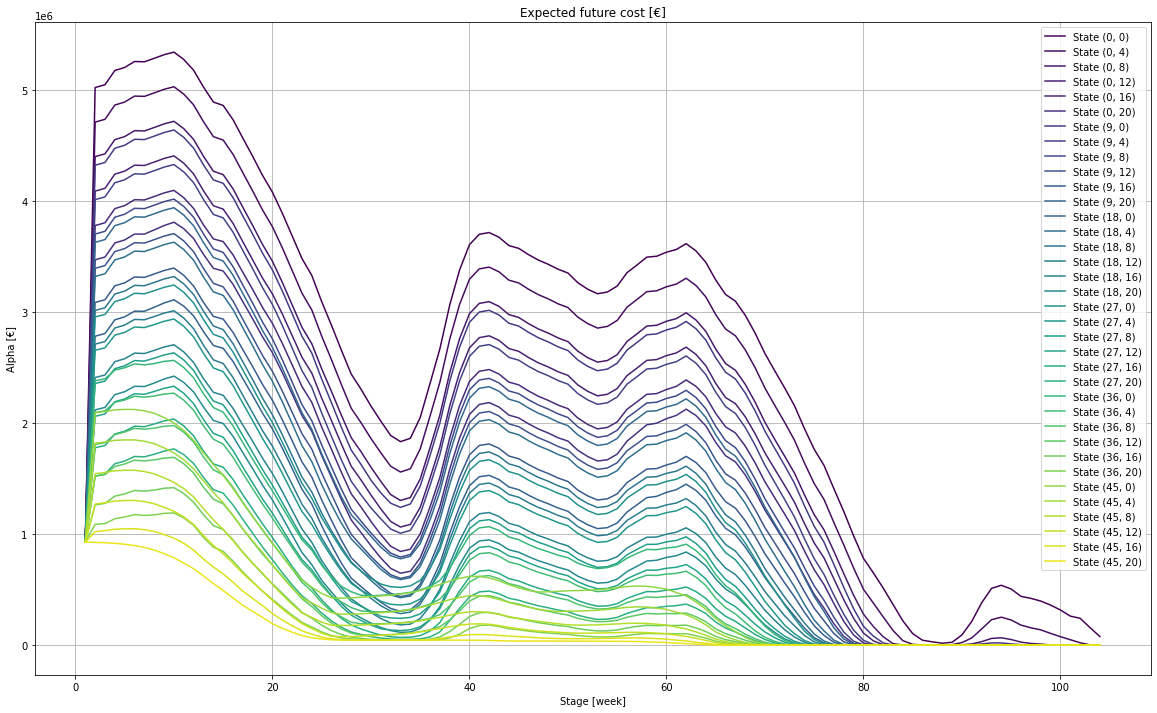

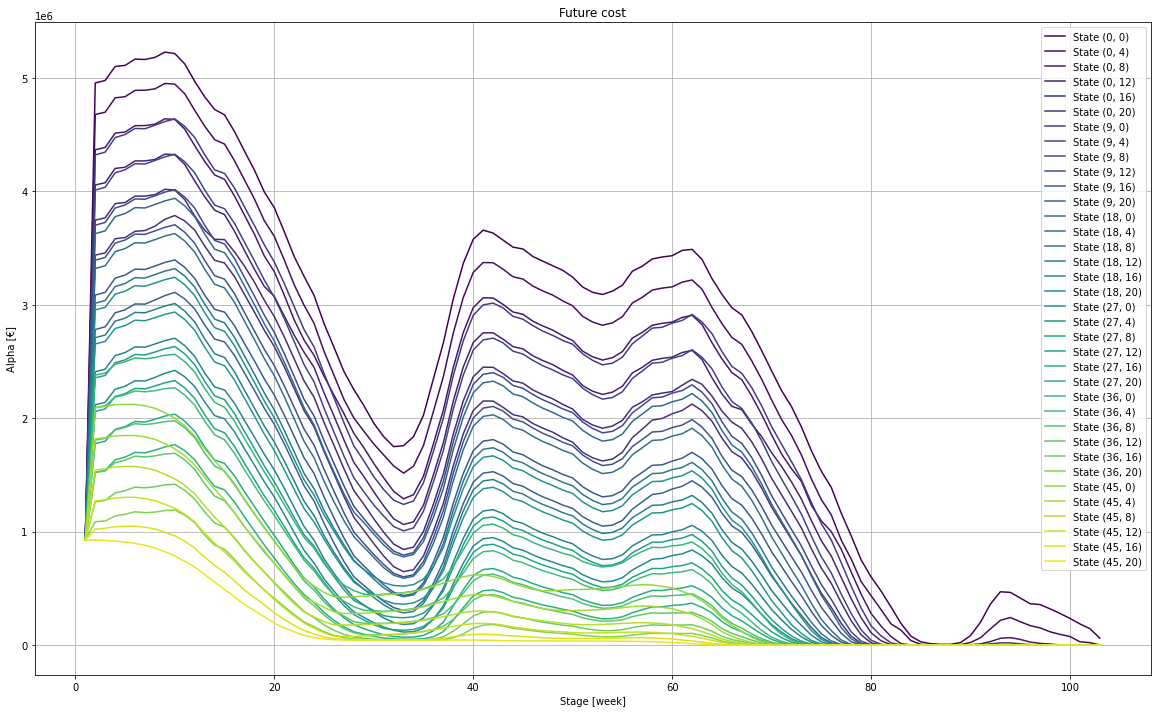

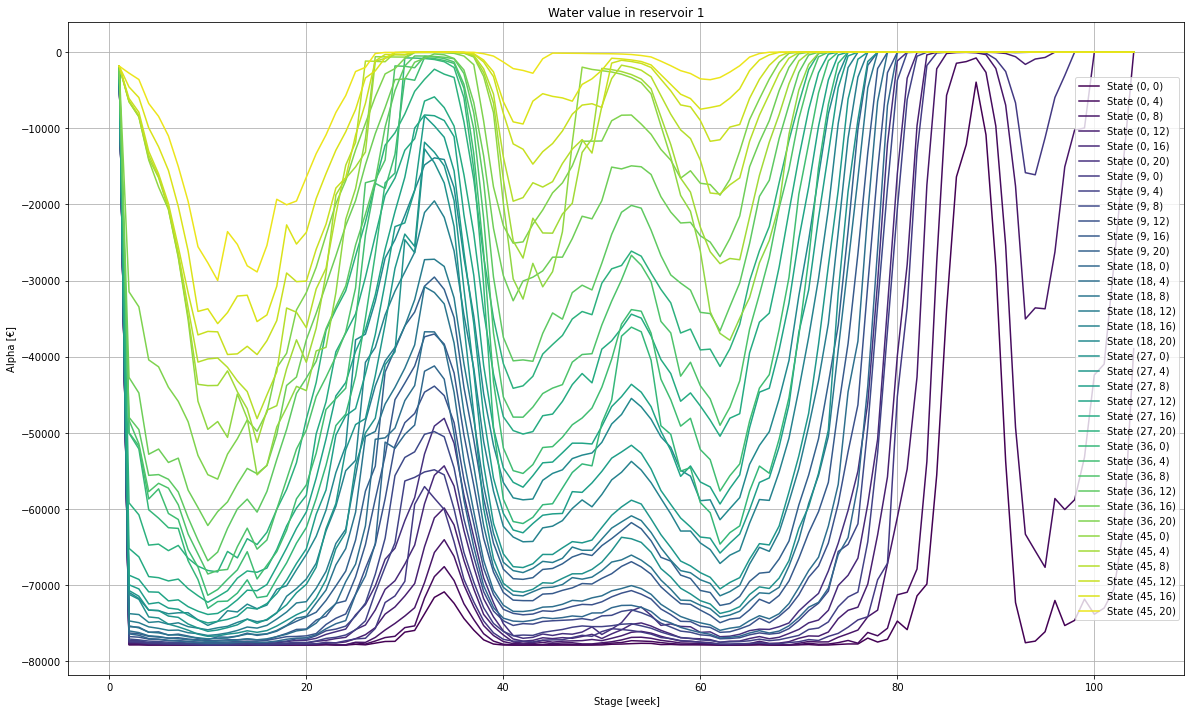

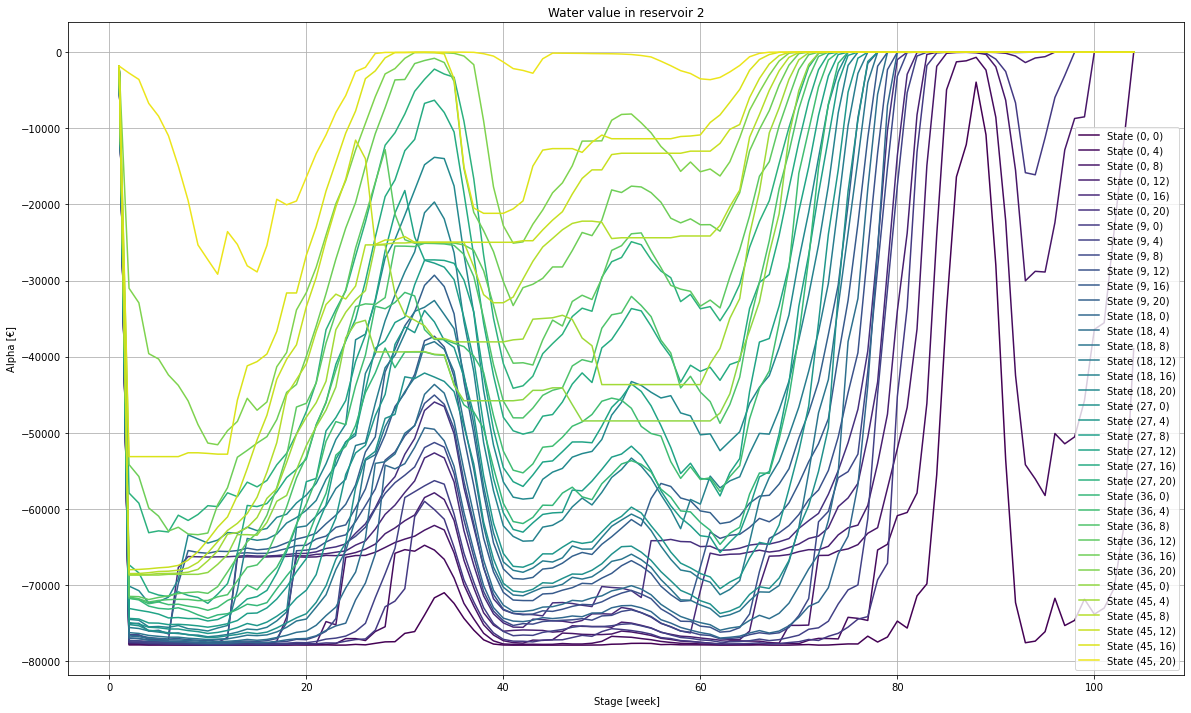

{(104, (0, 0)): 77662.02143268034, (104, (0, 4)): 0.0, (104, (0, 8)): 0.0, (104, (0, 12)): 0.0, (104, (0, 16)): 0.0, (104, (0, 20)): 0.0, (104, (9, 0)): 0.0, (104, (9, 4)): 0.0, (104, (9, 8)): 0.0, (104, (9, 12)): 0.0, (104, (9, 16)): 0.0, (104, (9, 20)): 0.0, (104, (18, 0)): 0.0, (104, (18, 4)): 0.0, (104, (18, 8)): 0.0, (104, (18, 12)): 0.0, (104, (18, 16)): 0.0, (104, (18, 20)): 0.0, (104, (27, 0)): 0.0, (104, (27, 4)): 0.0, (104, (27, 8)): 0.0, (104, (27, 12)): 0.0, (104, (27, 16)): 0.0, (104, (27, 20)): 0.0, (104, (36, 0)): 0.0, (104, (36, 4)): 0.0, (104, (36, 8)): 0.0, (104, (36, 12)): 0.0, (104, (36, 16)): 0.0, (104, (36, 20)): 0.0, (104, (45, 0)): 0.0, (104, (45, 4)): 0.0, (104, (45, 8)): 0.0, (104, (45, 12)): 0.0, (104, (45, 16)): 0.0, (104, (45, 20)): 0.0, (103, (0, 0)): 158132.51080411597, (103, (0, 4)): 2318.5789380744654, (103, (0, 8)): 0.0, (103, (0, 12)): 0.0, (103, (0, 16)): 0.0, (103, (0, 20)): 0.0, (103, (9, 0)): 0.0, (103, (9, 4)): 0.0, (103, (9, 8)): 0.0, (103, (9, 

In [9]:
from itertools import cycle
from matplotlib.cm import get_cmap

# Define your dictionaries and titles
dictionaries = [expected, alpha_dict, Dual_values1, Dual_values2]
titles = ["Expected future cost [€]", "Future cost", "Water value in reservoir 1", "Water value in reservoir 2"]

# Set a larger figure size
plt.figure(figsize=(20, 15))

# Define a cycle of colormaps for states
cmap = get_cmap("viridis")

# Iterate through the dictionaries
for dictionary, title in zip(dictionaries, titles):
    states = {}

    # Create a separate figure for each dictionary
    plt.figure(figsize=(20, 12))

    for key, value in dictionary.items():
        stage, state = key
        if stage <= 104:  # Filter stages 0-52
            if state not in states:
                states[state] = {"stages": [], "values": []}
            states[state]["stages"].append(stage)
            states[state]["values"].append(value)

    # Plot each state with a different color
    for i, (state, data) in enumerate(states.items()):
        color = cmap(i/len(states))
        plt.plot(data["stages"], data["values"], label=f"State {state}", color=color)

    # Add labels, title, and legend for the current dictionary
    plt.xlabel("Stage [week]")
    plt.ylabel("Alpha [€]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

print(expected)
print(Dual_values1)
print(Dual_values2)


In [10]:


# Create a DataFrame from the dictionary
df = pd.DataFrame(alpha_dict.values(), index=pd.MultiIndex.from_tuples(alpha_dict.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'Future_cost_s.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)


In [11]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(expected.values(), index=pd.MultiIndex.from_tuples(expected.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'PHI_hybrid_0.004.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

In [12]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(Dual_values1.values(), index=pd.MultiIndex.from_tuples(Dual_values1.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'WV1_hybrid_0.004.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

In [13]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(Dual_values2.values(), index=pd.MultiIndex.from_tuples(Dual_values2.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'WV2_hybrid_0.004.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

In [14]:
print(alpha_dict)

{(103, (0, 0)): 61196.15008438134, (103, (0, 4)): 2318.5789380744654, (103, (0, 8)): 0.0, (103, (0, 12)): 0.0, (103, (0, 16)): 0.0, (103, (0, 20)): 0.0, (103, (9, 0)): 0.0, (103, (9, 4)): 0.0, (103, (9, 8)): 0.0, (103, (9, 12)): 0.0, (103, (9, 16)): 0.0, (103, (9, 20)): 0.0, (103, (18, 0)): 0.0, (103, (18, 4)): 0.0, (103, (18, 8)): 0.0, (103, (18, 12)): 0.0, (103, (18, 16)): 0.0, (103, (18, 20)): 0.0, (103, (27, 0)): 0.0, (103, (27, 4)): 0.0, (103, (27, 8)): 0.0, (103, (27, 12)): 0.0, (103, (27, 16)): 0.0, (103, (27, 20)): 0.0, (103, (36, 0)): 0.0, (103, (36, 4)): 0.0, (103, (36, 8)): 0.0, (103, (36, 12)): 0.0, (103, (36, 16)): 0.0, (103, (36, 20)): 0.0, (103, (45, 0)): 0.0, (103, (45, 4)): 0.0, (103, (45, 8)): 0.0, (103, (45, 12)): 0.0, (103, (45, 16)): 0.0, (103, (45, 20)): 0.0, (102, (0, 0)): 145348.15127668617, (102, (0, 4)): 21706.713184954733, (102, (0, 8)): 0.0, (102, (0, 12)): 0.0, (102, (0, 16)): 0.0, (102, (0, 20)): 0.0, (102, (9, 0)): 0.0, (102, (9, 4)): 0.0, (102, (9, 8)): 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


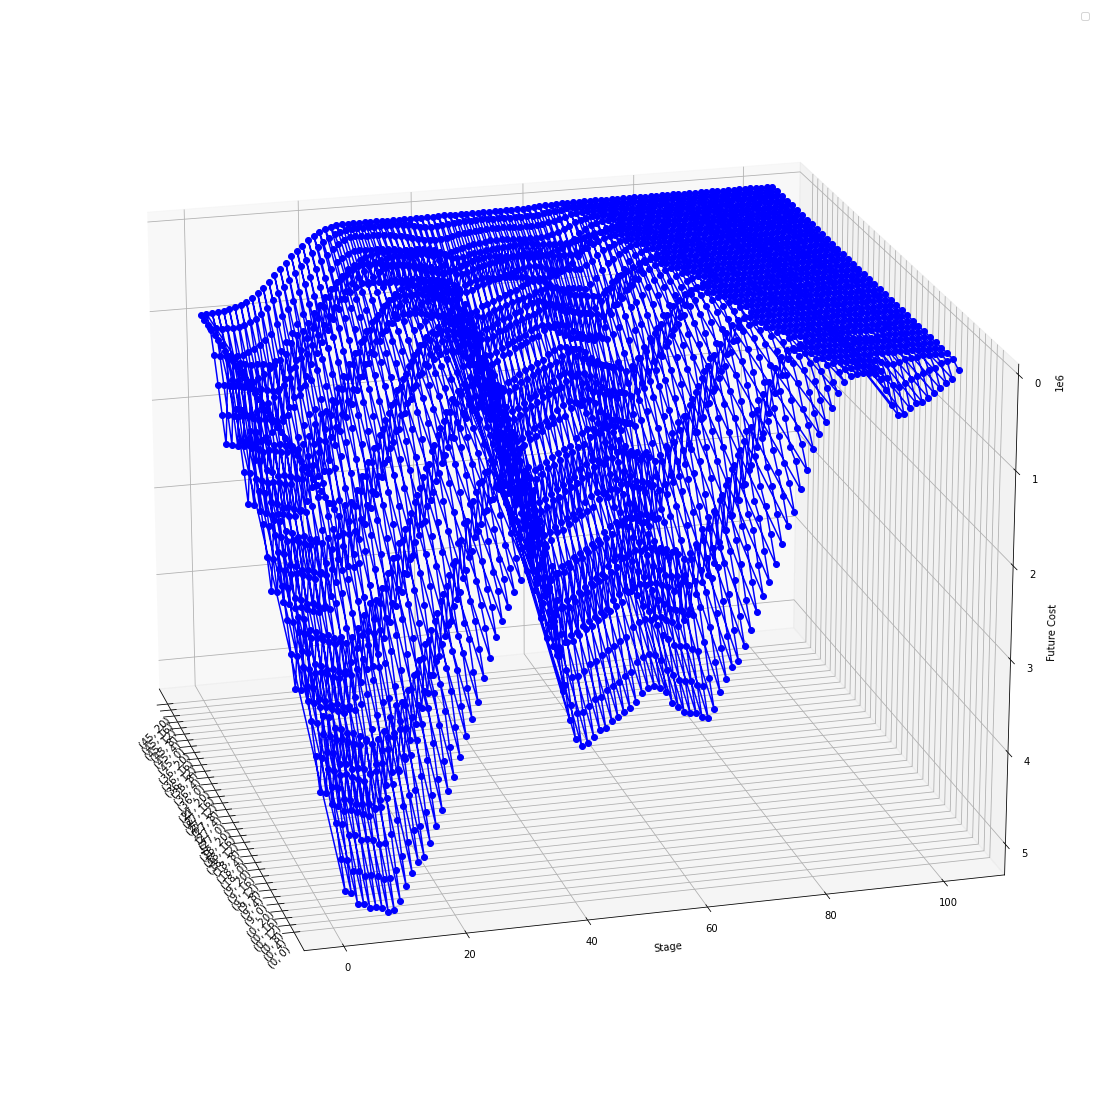

In [15]:
# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in alpha_dict.keys()]
state_tuples = [str(state) for stage, state in alpha_dict.keys()]
future_costs = list(alpha_dict.values())

# Create a 3D plot
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111, projection='3d')

# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]

# Plot the data points with stage on the y-axis and state on the x-axis
ax.plot(state_numeric, stages, future_costs, c='b', marker='o')
ax.view_init(-160, 15) 
# Set labels for the axes
ax.set_xticks(list(state_mapping.values()))
ax.set_xticklabels(list(state_mapping.keys()), rotation=45)
ax.set_xlabel('State (Tuple)')
ax.set_ylabel('Stage')
ax.set_zlabel('Future Cost')
plt.legend()

plt.show()

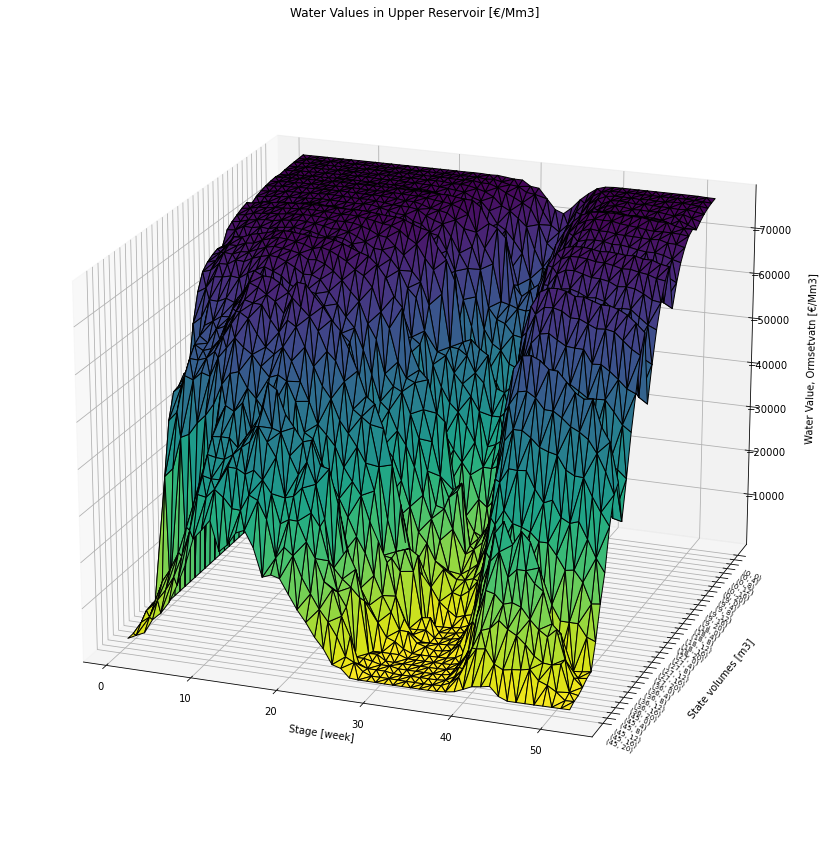

In [16]:
from mpl_toolkits.mplot3d import Axes3D


# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in Dual_values1.keys()]
state_tuples = [str(state) for stage, state in Dual_values1.keys()]
future_costs = list(Dual_values1.values())

# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]


# Filter data for stages 0 to 52
filtered_stages = [stage for stage in stages if stage <= 52]
filtered_indices = [i for i, stage in enumerate(stages) if stage <= 52]

filtered_state_numeric = np.array(state_numeric)[filtered_indices]
filtered_future_costs = np.array(future_costs)[filtered_indices]

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Create arrays for stages, state_numeric, and future_costs
stages_array = np.array(stages)
state_numeric_array = np.array(state_numeric)
future_costs_array = np.array(future_costs)

# Plot the 3D surface using plot_trisurf
ax.plot_trisurf(np.array(filtered_stages), filtered_state_numeric, filtered_future_costs, cmap='viridis', edgecolor='k')
ax.view_init(560, -110)
# Set labels for the axes with rotated and fewer tick labels, and adjust position
y_ticks = list(state_mapping.values())
y_labels = list(state_mapping.keys())
# Adjust the number of displayed ticks for better readability
stride = max(1, len(y_labels) // 36)  # Adjust the denominator for desired spacing
ax.set_yticks(y_ticks[::stride])
ax.set_yticklabels(y_labels[::stride], rotation=-20, ha='center', fontsize=7)   # Adjust rotation and ha as needed
ax.set_xlabel('Stage [week]')
ax.set_ylabel('State volumes [m3]', labelpad=20)
ax.set_zlabel('Water Value, Ormsetvatn [€/Mm3]', labelpad=20)

ax.tick_params(axis='y', pad=5)

# Adjust the position and spacing of y-axis ticks
#ax.yaxis.set_ticks_position('left')  # Set the ticks to the left side
#ax.yaxis.set_label_coords(-0.15, 0.5)  # Adjust the position as needed
#ax.yaxis.set_tick_params(pad=20)

plt.title("Water Values in Upper Reservoir [€/Mm3]")

# Add colorbar
#cbar = fig.colorbar(ax.plot_trisurf(stages_array, state_numeric_array, future_costs_array, cmap='viridis', edgecolor='k'), ax=ax, shrink=0.5, aspect=10)
#cbar.set_label('Water Value Reservoir 1 [€/Mm3]')

plt.show()

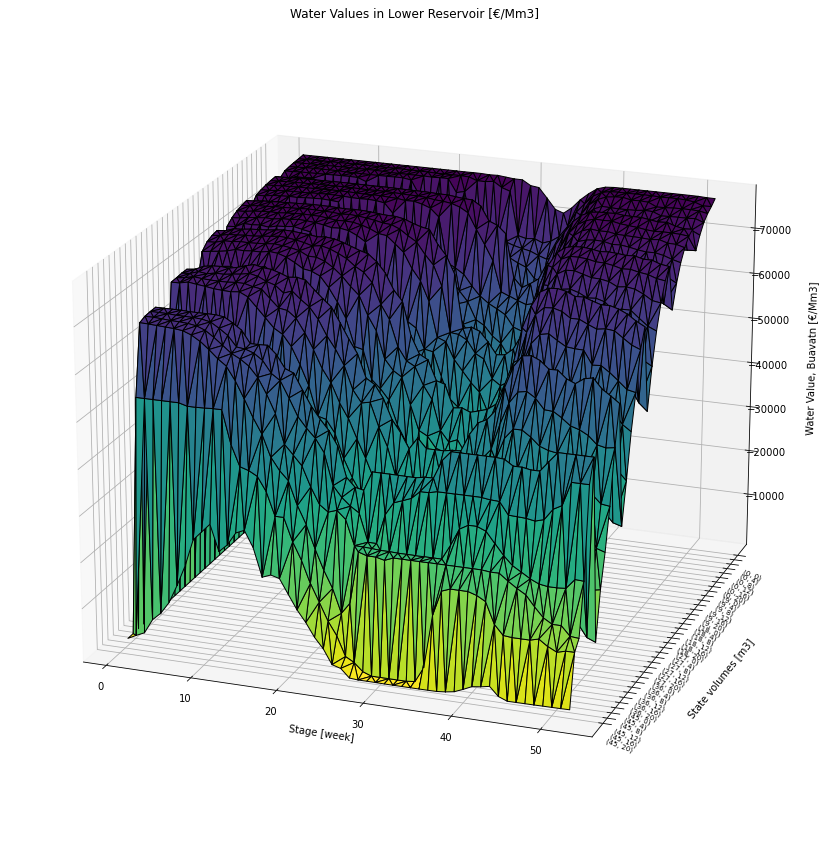

In [17]:
# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in Dual_values2.keys()]
state_tuples = [str(state) for stage, state in Dual_values2.keys()]
future_costs = list(Dual_values2.values())

# Create a 3D plot
# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Create arrays for stages, state_numeric, and future_costs
stages_array = np.array(stages)
state_numeric_array = np.array(state_numeric)
future_costs_array = np.array(future_costs)


# Filter data for stages 0 to 52
filtered_stages = [stage for stage in stages if stage <= 52]
filtered_indices = [i for i, stage in enumerate(stages) if stage <= 52]

filtered_state_numeric = np.array(state_numeric)[filtered_indices]
filtered_future_costs = np.array(future_costs)[filtered_indices]

# Plot the 3D surface using plot_trisurf
ax.plot_trisurf(np.array(filtered_stages), filtered_state_numeric, filtered_future_costs, cmap='viridis', edgecolor='k')
ax.view_init(560, -110)
# Set labels for the axes with rotated and fewer tick labels, and adjust position
y_ticks = list(state_mapping.values())
y_labels = list(state_mapping.keys())
# Adjust the number of displayed ticks for better readability
stride = max(1, len(y_labels) // 36)  # Adjust the denominator for desired spacing
ax.set_yticks(y_ticks[::stride])
ax.set_yticklabels(y_labels[::stride], rotation=-20, ha='center', fontsize=7)   # Adjust rotation and ha as needed
ax.set_xlabel('Stage [week]')
ax.set_ylabel('State volumes [m3]', labelpad=20)
ax.set_zlabel('Water Value, Buavatn [€/Mm3]', labelpad=20)

ax.tick_params(axis='y', pad=5)

# Adjust the position and spacing of y-axis ticks
#ax.yaxis.set_ticks_position('left')  # Set the ticks to the left side
#ax.yaxis.set_label_coords(-0.15, 0.5)  # Adjust the position as needed
#ax.yaxis.set_tick_params(pad=20)

plt.title("Water Values in Lower Reservoir [€/Mm3]")

# Add colorbar
#cbar = fig.colorbar(ax.plot_trisurf(stages_array, state_numeric_array, future_costs_array, cmap='viridis', edgecolor='k'), ax=ax, shrink=0.5, aspect=10)
#cbar.set_label('Water Value Reservoir 1 [€/Mm3]')

plt.show()